In [6]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def preprocesar_imagen(image_path):
    # Cargar la imagen
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {image_path}")

    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Aplicar desenfoque para reducir el ruido
    #blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Detectar bordes con Canny
    edges = cv2.Canny(gray, 50, 150)
    
    # Dilatar los bordes para cerrar huecos
    dilated = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations=3)
    
    return image, dilated

In [8]:
def encontrar_viñetas(image, edges):
    # Encontrar contornos
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calcular el área total de la imagen
    total_area = image.shape[0] * image.shape[1]
    
    # Inicializar la lista de viñetas consolidadas
    viñetas_consolidadas = []
    
    # Filtrar contornos por área y aspecto
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(contour)
        if 0.1 < aspect_ratio < 3.0 and 0.01 < area / total_area < 0.9:  # Ajusta estos valores según sea necesario
            viñetas_consolidadas.append((x, y, w, h))
    
    # Eliminar contornos internos
    viñetas_finales = []
    for viñeta in viñetas_consolidadas:
        x, y, w, h = viñeta
        agregar_nueva = True
        for x2, y2, w2, h2 in viñetas_consolidadas:
            if x < x2 and y < y2 and x + w > x2 + w2 and y + h > y2 + h2:
                agregar_nueva = False
                break
        if agregar_nueva:
            viñetas_finales.append(viñeta)
    
    # Consolidar viñetas cercanas
    viñetas_finales = []
    for viñeta in viñetas_consolidadas:
        x, y, w, h = viñeta
        agregar_nueva = True
        for i, (x2, y2, w2, h2) in enumerate(viñetas_finales):
            if abs(x - x2) < w * 0.5 and abs(y - y2) < h * 0.5:
                viñetas_finales[i] = (min(x, x2), min(y, y2), max(x + w, x2 + w2) - min(x, x2), max(y + h, y2 + h2) - min(y, y2))
                agregar_nueva = False
                break
        if agregar_nueva:
            viñetas_finales.append(viñeta)
    
    return viñetas_finales

In [9]:
def dibujar_y_guardar_viñetas(image, viñetas, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Dibujar y guardar las viñetas consolidadas
    for i, (x, y, w, h) in enumerate(reversed(viñetas)):
        # Extraer y guardar la viñeta
        viñeta = image[y:y+h, x:x+w]
        cv2.imwrite(os.path.join(output_folder, f"panel_{i + 1}.jpg"), viñeta)
        
        # Dibujar rectángulo en la imagen original
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 4)
    
    # Convertir la imagen de BGR a RGB para matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Ajustar el tamaño de la figura
    plt.figure(figsize=(20, 20))
    
    # Mostrar la imagen con los rectángulos dibujados usando matplotlib
    plt.imshow(image_rgb)
    plt.title('Viñetas detectadas')
    plt.axis('off')  # Ocultar los ejes
    plt.show()


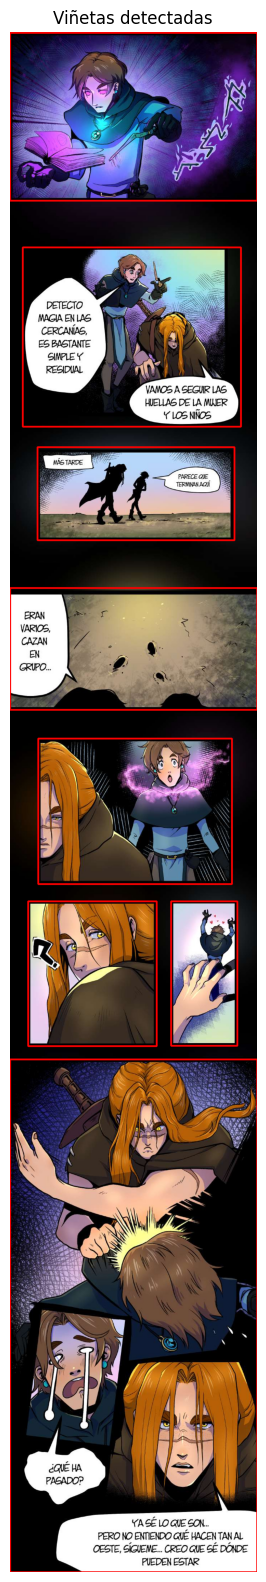

Se han detectado 8 viñetas.


In [10]:
# Ruta de la imagen de cómic
image_path = r'data\output\divide_pages_test\pages_images_raw\page3_img.jpeg'
output_folder = r'data\output\divide_images_test'

# Preprocesar la imagen
image, edges = preprocesar_imagen(image_path)

# Encontrar viñetas y consolidarlas
viñetas_consolidadas = encontrar_viñetas(image, edges)

# Dibujar y guardar viñetas consolidadas
dibujar_y_guardar_viñetas(image, viñetas_consolidadas, output_folder)

# Encontrar viñetas y consolidarlas
viñetas_consolidadas = encontrar_viñetas(image, edges)

# Obtener la cantidad de viñetas detectadas
cantidad_viñetas = len(viñetas_consolidadas)

print(f"Se han detectado {cantidad_viñetas} viñetas.")